This program trains a Long Short-Term Memory (LSTM) neural network to classify 3D hand movement trajectories into predefined target classes from point 1 to 9. Performance metrics and confusion matrix are included and it also saves the model. The loss graph shows both training and validation loss going down and performance metrics looks accurate enough.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import joblib


In [2]:
# Load your dataset
df = pd.read_csv("hand_trajectory_labeled_new_edit.csv")

# Use x_px, y_px, z_mm as input features
grouped = df.groupby(['point_id', 'sequence_id'])

sequences = []
labels = []

for (point_id, seq_id), group in grouped:
    coords = group[['x_px', 'y_px', 'z_mm']].values
    sequences.append(coords)
    labels.append(point_id)

MAX_LEN = 50

# Pad/truncate sequences to a fixed length
padded_sequences = pad_sequences(sequences, maxlen= MAX_LEN, dtype='float32', padding='post', truncating='post')

# Encode the point_id labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Save the label encoder
joblib.dump(label_encoder, "label_encoder_new.pkl")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.4, stratify=y, random_state=42)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Define the LSTM model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(MAX_LEN, 3)),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1)
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# Use early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=20,
    batch_size=16,
    callbacks=[early_stop]
)

# Save the model
model.save("lstm_index_finger_model_new.keras")

# Evaluate final test accuracy
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/20


C:\Users\goga_\anaconda3\envs\hand\lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.1456 - loss: 2.1894 - val_accuracy: 0.3889 - val_loss: 2.0956
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2956 - loss: 2.1262 - val_accuracy: 0.3704 - val_loss: 1.9839
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2621 - loss: 2.0155 - val_accuracy: 0.3704 - val_loss: 1.8842
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3671 - loss: 1.8802 - val_accuracy: 0.5185 - val_loss: 1.7739
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4199 - loss: 1.8079 - val_accuracy: 0.3704 - val_loss: 1.6935
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6015 - loss: 1.6023 - val_accuracy: 0.7407 - val_loss: 1.4592
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6365 - loss: 1.4974 - val_accuracy: 0.7222 - val_loss: 1.2351
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7492 - loss: 1.3219 - val_accuracy: 0.8889 - val_loss: 1.0932
Epoch 9/20


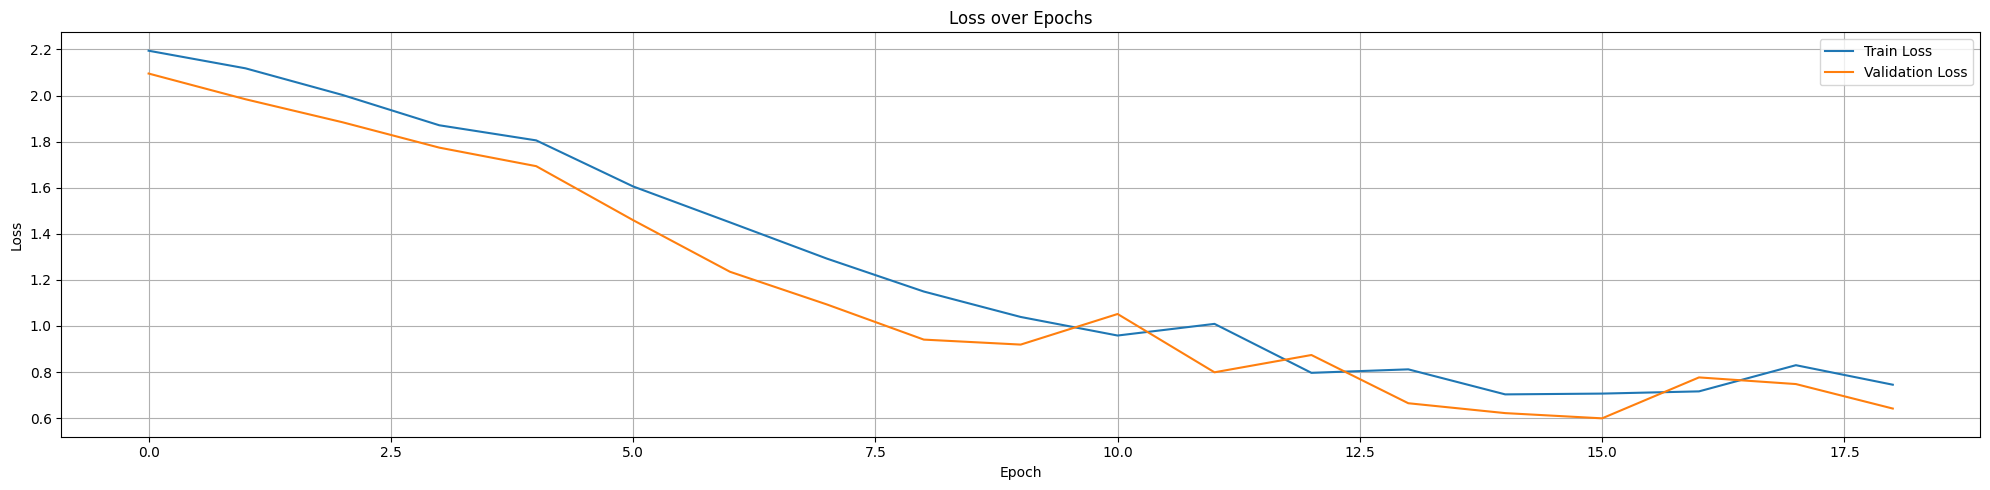

In [3]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


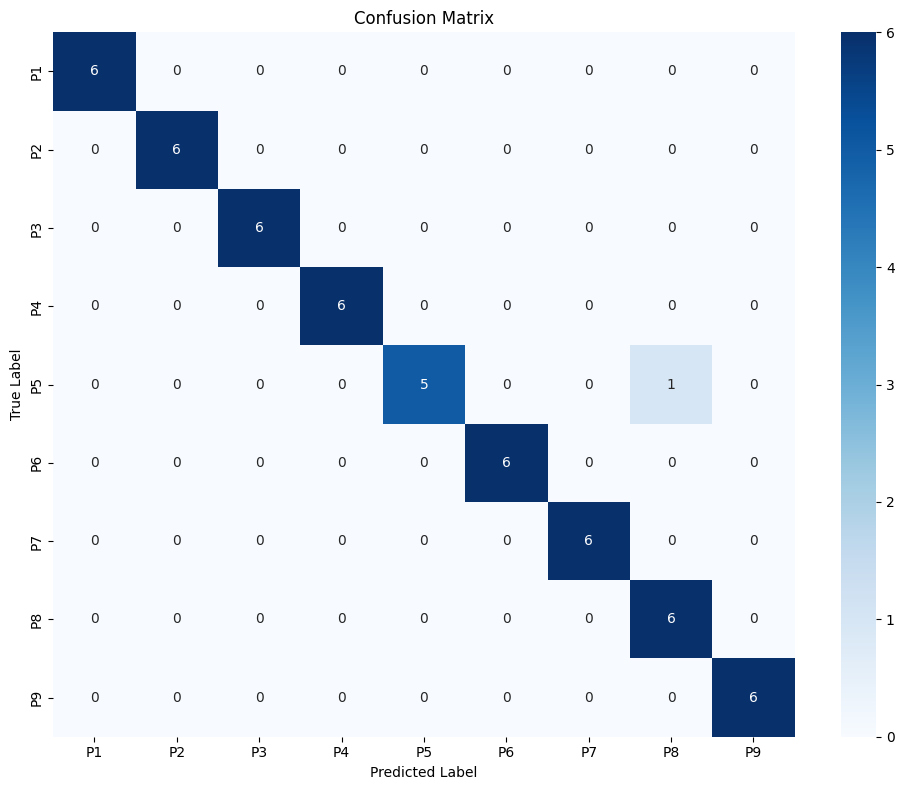

              precision    recall  f1-score   support

          P1       1.00      1.00      1.00         6
          P2       1.00      1.00      1.00         6
          P3       1.00      1.00      1.00         6
          P4       1.00      1.00      1.00         6
          P5       1.00      0.83      0.91         6
          P6       1.00      1.00      1.00         6
          P7       1.00      1.00      1.00         6
          P8       0.86      1.00      0.92         6
          P9       1.00      1.00      1.00         6

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Predict on test set
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_labels = label_encoder.classes_

# Plot with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Optional: detailed metrics
print(classification_report(y_true, y_pred, target_names=class_labels))


In [11]:
import cv2
import mediapipe as mp
import pyrealsense2 as rs
import numpy as np
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib

# ─────────────── Load Model and Encoder ───────────────
model = load_model("lstm_index_finger_model_new.keras")
label_encoder = joblib.load("label_encoder_new.pkl")

MAX_LEN = 50
trajectory = []

# ─────────────── RealSense Setup ───────────────
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
pipeline.start(config)
align = rs.align(rs.stream.color)

# ─────────────── MediaPipe Setup ───────────────
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1,
                       min_detection_confidence=0.7,
                       min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

try:
    while True:
        frames = pipeline.wait_for_frames()
        aligned = align.process(frames)
        depth_frame = aligned.get_depth_frame()
        color_frame = aligned.get_color_frame()

        if not depth_frame or not color_frame:
            continue

        color_image = np.asanyarray(color_frame.get_data())
        frame_rgb = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(color_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                h, w, _ = color_image.shape
                lm = hand_landmarks.landmark[8]
                cx, cy = int(lm.x * w), int(lm.y * h)
                cx, cy = np.clip(cx, 0, w - 1), np.clip(cy, 0, h - 1)
                z = depth_frame.get_distance(cx, cy) * 1000  # mm
                trajectory.append([cx, cy, z])

                if len(trajectory) > MAX_LEN:
                    trajectory = trajectory[-MAX_LEN:]

                if len(trajectory) >= MAX_LEN:
                    input_seq = pad_sequences([trajectory], maxlen=MAX_LEN, dtype='float32', padding='post')
                    probs = model.predict(input_seq, verbose=0)
                    pred_class = np.argmax(probs)
                    label = label_encoder.inverse_transform([pred_class])[0]

                    # Show prediction
                    cv2.putText(color_image, f"Predicted: {label}", (10, 60),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                # Draw indicator
                cv2.circle(color_image, (cx, cy), 8, (0, 255, 0), -1)
                cv2.putText(color_image, f"{round(z)} mm", (cx + 10, cy - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

        cv2.imshow("Real-Time Prediction", color_image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

except KeyboardInterrupt:
    print("Interrupted by user")

finally:
    print("Closing")
    pipeline.stop()
    cv2.destroyAllWindows()


Closing


In [8]:
import cv2
import mediapipe as mp
import pyrealsense2 as rs
import numpy as np
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
from collections import deque, Counter

# ─────────────── Load Model and Encoder ───────────────
model = load_model("lstm_index_finger_model_new.keras")
label_encoder = joblib.load("label_encoder_new.pkl")

MAX_LEN = 50
trajectory = []
recent_predictions = deque(maxlen=10)
stable_label = None

# ─────────────── RealSense Setup ───────────────
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
pipeline.start(config)
align = rs.align(rs.stream.color)

# ─────────────── MediaPipe Setup ───────────────
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1,
                       min_detection_confidence=0.7,
                       min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

try:
    while True:
        frames = pipeline.wait_for_frames()
        aligned = align.process(frames)
        depth_frame = aligned.get_depth_frame()
        color_frame = aligned.get_color_frame()

        if not depth_frame or not color_frame:
            continue

        color_image = np.asanyarray(color_frame.get_data())
        frame_rgb = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(color_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                h, w, _ = color_image.shape
                lm = hand_landmarks.landmark[8]
                cx, cy = int(lm.x * w), int(lm.y * h)
                cx, cy = np.clip(cx, 0, w - 1), np.clip(cy, 0, h - 1)
                z = depth_frame.get_distance(cx, cy) * 1000  # mm
                trajectory.append([cx, cy, z])

                if len(trajectory) > MAX_LEN:
                    trajectory = trajectory[-MAX_LEN:]

                if len(trajectory) >= MAX_LEN:
                    input_seq = pad_sequences([trajectory], maxlen=MAX_LEN, dtype='float32', padding='post')
                    probs = model.predict(input_seq, verbose=0)
                    pred_class = np.argmax(probs)
                    predicted_label = label_encoder.inverse_transform([pred_class])[0]

                    recent_predictions.append(predicted_label)
                    most_common = Counter(recent_predictions).most_common(1)[0]

                    if most_common[1] >= 6:
                        stable_label = most_common[0]

                    if stable_label:
                        cv2.putText(color_image, f"Predicted: {stable_label}", (10, 60),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                # Draw indicator
                cv2.circle(color_image, (cx, cy), 8, (0, 255, 0), -1)
                cv2.putText(color_image, f"{round(z)} mm", (cx + 10, cy - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

        cv2.imshow("Real-Time Prediction", color_image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

except KeyboardInterrupt:
    print("Interrupted by user")

finally:
    print("Closing")
    pipeline.stop()
    cv2.destroyAllWindows()


Closing
